In [2]:
import torch
from torch import nn
from torch import optim
from torchvision.transforms import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

torch.Size([3, 32, 32])


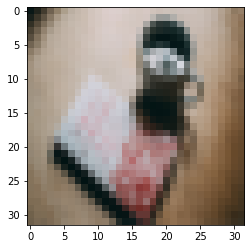

In [3]:
transform = transforms.Compose([
                                transforms.Resize((32, 32)),
                                transforms.ToTensor()
])

flat_img = 3072

img = Image.open('./pic/bk.jpg')
real_img = transform(img)
plt.imshow(np.transpose(real_img.numpy(), (1, 2, 0)))
print(real_img.size())

In [4]:
torch.manual_seed(2)

fake_img = torch.rand(1, 100)
fake_img.size(), fake_img.min(), fake_img.max()

(torch.Size([1, 100]), tensor(0.0021), tensor(0.9809))

In [5]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Sequential(
        nn.Linear(flat_img, 8000),
        nn.ReLU(),
        nn.Linear(8000, 1),
        nn.Sigmoid()
    )

  def forward(self, img):
    img = img.view(1, -1)
    out = self.linear(img)

    return out

In [6]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Sequential(
        nn.Linear(100, 8000),
        nn.LeakyReLU(),
        nn.Linear(8000, 4000),
        nn.LeakyReLU(),
        nn.Linear(4000, flat_img)
    )

  def forward(self, latent_space):
    latent_space = latent_space.view(1, -1)
    out = self.linear(latent_space)

    return out

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

discr = Discriminator().to(device)
gen = Generator().to(device)
print(discr)
print(gen)

Discriminator(
  (linear): Sequential(
    (0): Linear(in_features=3072, out_features=8000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8000, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
Generator(
  (linear): Sequential(
    (0): Linear(in_features=100, out_features=8000, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=8000, out_features=4000, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=4000, out_features=3072, bias=True)
  )
)


In [13]:
opt_d = optim.SGD(discr.parameters(), lr=0.002, momentum=0.9)
opt_g = optim.SGD(gen.parameters(), lr=0.002, momentum=0.9)

criterion = nn.BCELoss()

In [14]:
epochs = 800
discr_e = 4
gen_e =3

for epoch in tqdm(range(epochs),total=epochs):
    
    for k in range(discr_e):
        opt_d.zero_grad()
        
        out_d1 = discr(real_img.to(device))
        loss_d1 = criterion(out_d1,torch.ones((1,1)).to(device))
        loss_d1.backward()
        
        out_d2 = gen(fake_img.to(device)).detach()
        loss_d2 = criterion(discr(out_d2.to(device)),torch.zeros((1,1)).to(device))
        loss_d2.backward()
        
        opt_d.step()
        
    for i in range(gen_e):
        opt_g.zero_grad()
        
        out_g = gen(fake_img.to(device))
        
        loss_g = torch.log(1.0 - (discr(out_g.to(device))))
        loss_g.backward()
        
        opt_g.step()
torch.cuda.empty_cache()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


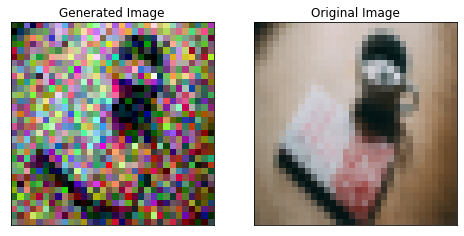

In [11]:
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.title("Generated Image")
plt.xticks([])
plt.yticks([])
plt.imshow(np.transpose(out_g.resize(3, 32, 32).cpu().detach().numpy(), (1, 2 , 0)))

plt.subplot(1, 2, 2)
plt.title("Original Image")
plt.xticks([])
plt.yticks([])
plt.imshow(np.transpose(real_img.numpy(), (1, 2, 0)))
plt.show()